In [1]:
# Imports

import os
import shutil
from random import shuffle
import pandas as pd
import numpy as np
import torchmetrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
import plotly.express as px

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
import torchvision
from torchvision import transforms as T
import pytorch_lightning as pl
from pytorch_lightning.metrics.classification import Accuracy
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

In [2]:
# Getting our images in the right folders so we can use ImageFolder

project_path = os.getcwd().replace('/notebooks', '')
csv_path = project_path + '/data/HAM10000_metadata'
metadata = pd.read_csv(csv_path)

lesion_ids = metadata['lesion_id'].unique()
shuffle(lesion_ids)
lesion_ids = list(lesion_ids)

val_size = 0.15
test_size = 0.15

def set_membership(lesion_id):
    idx = lesion_ids.index(lesion_id)
    if idx < test_size*len(lesion_ids):
        return 'test'
    elif idx < (test_size+val_size)*len(lesion_ids):
        return 'val'
    else:
        return 'train'

for i in ['train', 'val', 'test']:
    path = project_path + '/data/images/' + i
    if not os.path.exists(path):
        os.mkdir(path)

for index, row in metadata.iterrows():
    destination_set = set_membership(row['lesion_id'])
    source = project_path + '/data/images/' + row['image_id'] + '.jpg'
    destination = project_path + '/data/images/' + destination_set + '/' + row['dx'] + '/' + row['image_id'] + '.jpg'
    destination_folder = project_path + '/data/images/' + destination_set + '/' + row['dx']
    if not os.path.exists(destination_folder):
        os.mkdir(destination_folder)
    if os.path.exists(source):
        shutil.move(source, destination)

In [3]:
# Setting up our dataloaders

labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

def estimate_weights_mfb(labels):
    frequencies = []
    for label in labels:
        count = len(metadata[metadata['dx'] == label]['dx'])
        frequencies.append(count)
    median_freq = np.median(frequencies)
    weights = [median_freq/freq for freq in frequencies]
    return weights

def sampler_weights(dataset, class_weights):
    weights = []
    for img, label in dataset:
        weights.append(class_weights[label])
    return torch.tensor(weights)

train_transform = T.Compose([
    T.ToTensor(),
    #T.CenterCrop((448, 576)),
    T.RandomCrop((448, 448)),
    T.Resize((224, 224)),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # ImageNet mean and std dev
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(90),
    #T.RandomPerspective(distortion_scale=0.6, p=1.0),
    #T.RandomGrayscale(p=0.1),
])

test_transform = T.Compose([
    T.ToTensor(),
    #T.CenterCrop((448, 576)),
    T.RandomCrop((448, 448)),
    T.Resize((224, 224)),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

batch_size = 12
num_workers = 8
class_weights = estimate_weights_mfb(labels)
train_ds = torchvision.datasets.ImageFolder(project_path + '/data/images/train', transform=train_transform)
val_ds = torchvision.datasets.ImageFolder(project_path + '/data/images/val', transform=test_transform)
test_ds = torchvision.datasets.ImageFolder(project_path + '/data/images/test', transform=test_transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers, sampler=WeightedRandomSampler(sampler_weights(train_ds, class_weights), len(train_ds), replacement=True))
val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers, sampler=WeightedRandomSampler(sampler_weights(val_ds, class_weights), len(val_ds), replacement=True))
test_loader = DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers, sampler=WeightedRandomSampler(sampler_weights(test_ds, class_weights), len(test_ds), replacement=True))

In [4]:
# Architecture specification

class LeNet(pl.LightningModule):
    def __init__(self, lr=1e-3, dropout=0.2):
        super().__init__()
        self.lr = lr
        self.accuracy = Accuracy()

        self.lenet = nn.Sequential(
            nn.Conv2d(3, 16, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout),
            nn.Conv2d(16, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout),
            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout*2),
            nn.Flatten(),
            nn.Linear(32*28*28, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 7)
        )

    def forward(self, x):
        return self.lenet(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
        return {
           'optimizer': optimizer,
           'lr_scheduler': scheduler,
           'monitor': 'val_loss'
        }

    def training_step(self, train_batch, batch_idx):
        x, y_true = train_batch
        y_pred = self.lenet(x)
        loss = F.cross_entropy(y_pred, y_true)
        acc = self.accuracy(torch.argmax(y_pred, dim=1), y_true)
        self.log('train_loss', loss, prog_bar=False, on_step=False, on_epoch=True)
        self.log('train_accuracy', acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y_true = val_batch
        y_pred = self.lenet(x)
        loss = F.cross_entropy(y_pred, y_true)
        acc = self.accuracy(torch.argmax(y_pred, dim=1), y_true)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_accuracy', acc, prog_bar=True)

In [7]:
# Init model and trainer

logger = CSVLogger("logs", name="LeNetLike", version='1.0')
callbacks = [
    EarlyStopping('val_accuracy', mode='max', patience=5),
    LearningRateMonitor(logging_interval='step'),
    ]
trainer = pl.Trainer(gpus=1, auto_lr_find=False, max_epochs=50, logger=logger, callbacks=callbacks)
model = LeNet(lr=3e-4)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | accuracy | Accuracy   | 0     
1 | lenet    | Sequential | 13.1 M
----------------------------------------
13.1 M    Trainable params
0         Non-trainable params
13.1 M    Total params
52.480    Total estimated model params size (MB)
Finding best initial lr: 100%|██████████| 500/500 [00:31<00:00, 12.62it/s]Restored states from the checkpoint file at /home/ryan/Documents/Springboard/Cancer-Detection-Capstone/notebooks/lr_find_temp_model.ckpt
Learning rate set to 0.002118050896056014
<ipython-input-6-696ed6f4c4e3>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Suggested LR: 0.002118050896056014


Finding best initial lr: 100%|██████████| 500/500 [00:33<00:00, 15.01it/s]


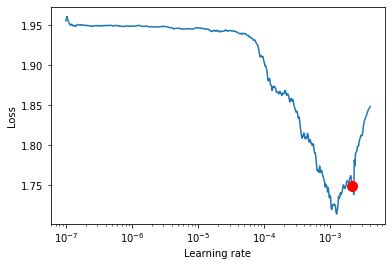

In [6]:
# Optionally use lrfinder

lr_finder = trainer.tuner.lr_find(model, train_loader, val_loader, num_training=500, update_attr=True, min_lr=1e-7, max_lr=4e-3)
print(f'Suggested LR: {lr_finder.suggestion()}')
fig = lr_finder.plot(suggest=True)
fig.show()

In [8]:
# Train

trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ryan/anaconda3/envs/ml/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Experiment logs directory logs/LeNetLike/1.0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name     | Type       | Params
----------------------------------------
0 | accuracy | Accuracy   | 0     
1 | lenet    | Sequential | 13.1 M
----------------------------------------
13.1 M    Trainable params
0         Non-trainable params
13.1 M    Total params
52.480    Total estimated model params size (MB)


Epoch 18: 100%|██████████| 710/710 [00:48<00:00, 14.74it/s, loss=0.751, v_num=1.0, val_loss=1.360, val_accuracy=0.536, train_accuracy=0.714]


In [9]:
# Visualize losses/metrics

log_dir = project_path + '/notebooks/logs/LeNetLike/1.0/'
log = pd.read_csv(os.path.join(log_dir, 'metrics.csv'))

train_log = log[['step', 'train_loss']].dropna().rename(columns={'train_loss': 'loss'})
train_log['set'] = 'train'
val_log = log[['step', 'val_loss']].dropna().rename(columns={'val_loss': 'loss'})
val_log['set'] = 'val'

log = train_log.append(val_log)
log = log.sort_values(by=['step'])

fig = px.line(log, x='step', y='loss', color='set')
fig.show()

log = pd.read_csv(os.path.join(log_dir, 'metrics.csv'))

train_log = log[['step', 'train_accuracy']].dropna().rename(columns={'train_accuracy': 'accuracy'})
train_log['set'] = 'train'
val_log = log[['step', 'val_accuracy']].dropna().rename(columns={'val_accuracy': 'accuracy'})
val_log['set'] = 'val'

log = train_log.append(val_log)
log = log.sort_values(by=['step'])

fig = px.line(log, x='step', y='accuracy', color='set')
fig.show()

In [ ]:
# Load a model we want to check out.

path = project_path + '/models/LeNetLike.pth'
#model.load_state_dict(torch.load(path))

/home/ryan/anaconda3/envs/ml/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning:

21 nan values found in confusion matrix have been replaced with zeros.

/home/ryan/anaconda3/envs/ml/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning:

7 nan values found in confusion matrix have been replaced with zeros.

/home/ryan/anaconda3/envs/ml/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning:

14 nan values found in confusion matrix have been replaced with zeros.

/home/ryan/anaconda3/envs/ml/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning:

35 nan values found in confusion matrix have been replaced with zeros.



<AxesSubplot:>

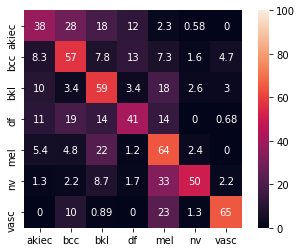

In [10]:
# Confusion matrix

confmat = torchmetrics.ConfusionMatrix(num_classes=7, normalize='true')
model.eval()
with torch.no_grad():
        for x, y_true in val_loader:
                y_pred = F.softmax(model(x), dim=1)
                confmat(y_pred, y_true)

classes = ('akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc')
sns.heatmap(confmat.compute()*100.0, annot=True, square=True, vmin=0.0, vmax=100.0, xticklabels=classes, yticklabels=classes)

In [11]:
# Save the model if we like it.

path = project_path + '/models/LeNetLike.pth'
#torch.save(model.state_dict(), path)

In [24]:
# ResNet time

class ResNet(pl.LightningModule):
    def __init__(self, lr=1e-3, freeze=True):
        super().__init__()
        self.lr = lr
        self.accuracy = Accuracy()

        self.resnet = torchvision.models.resnet50(pretrained=True)
        if freeze:
            for param in model.parameters():
                param.requires_grad = False
        self.resnet.fc = nn.Sequential(
            # nn.Dropout(0.5),
            # nn.Linear(512, 512),
            # nn.ReLU(),
            nn.Dropout(0.0),
            nn.Linear(2048, 7)
        )

    def forward(self, x):
        return self.resnet(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
        return {
           'optimizer': optimizer,
           'lr_scheduler': scheduler,
           'monitor': 'val_loss'
        }

    def training_step(self, train_batch, batch_idx):
        x, y_true = train_batch
        y_pred = self.resnet(x)
        loss = F.cross_entropy(y_pred, y_true)
        acc = self.accuracy(F.softmax(y_pred, dim=1), y_true)
        self.log('train_loss', loss, prog_bar=False, on_step=False, on_epoch=True)
        self.log('train_accuracy', acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y_true = val_batch
        y_pred = self.resnet(x)
        loss = F.cross_entropy(y_pred, y_true)
        acc = self.accuracy(F.softmax(y_pred, dim=1), y_true)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_accuracy', acc, prog_bar=True)

In [25]:
# Init model and trainer

logger = CSVLogger("logs", name="ResNet", version='1.0')
callbacks = [
    EarlyStopping('val_accuracy', mode='max', patience=10),
    LearningRateMonitor(logging_interval='step'),
    ]
trainer = pl.Trainer(gpus=1, auto_lr_find=False, max_epochs=50, logger=logger, callbacks=callbacks, log_every_n_steps=10)
model = ResNet(lr=5e-4, freeze=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type     | Params
--------------------------------------
0 | accuracy | Accuracy | 0     
1 | resnet   | ResNet   | 23.5 M
--------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.090    Total estimated model params size (MB)
Finding best initial lr: 100%|██████████| 100/100 [00:21<00:00,  4.80it/s]Restored states from the checkpoint file at /home/ryan/Documents/Springboard/Cancer-Detection-Capstone/notebooks/lr_find_temp_model.ckpt
Learning rate set to 0.0005248074602497726
<ipython-input-19-a6fccbd41cea>:6: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



Suggested LR: 0.0005248074602497726


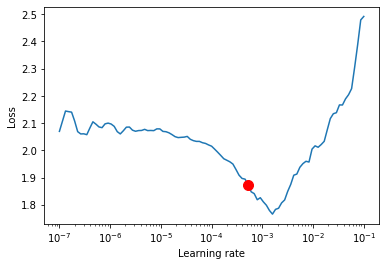

In [19]:
# Optionally use lrfinder

lr_finder = trainer.tuner.lr_find(model, train_loader, val_loader, num_training=100, update_attr=True, min_lr=1e-7, max_lr=1e-1)
print(f'Suggested LR: {lr_finder.suggestion()}')
fig = lr_finder.plot(suggest=True)
fig.show()

In [26]:
# Train

trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type     | Params
--------------------------------------
0 | accuracy | Accuracy | 0     
1 | resnet   | ResNet   | 23.5 M
--------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.090    Total estimated model params size (MB)


Epoch 17: 100%|██████████| 710/710 [02:14<00:00,  5.29it/s, loss=0.352, v_num=1.0, val_loss=1.260, val_accuracy=0.687, train_accuracy=0.870]


In [27]:
# Visualize losses/metrics

log_dir = project_path + '/notebooks/logs/ResNet/1.0/'
log = pd.read_csv(os.path.join(log_dir, 'metrics.csv'))

train_log = log[['step', 'train_loss']].dropna().rename(columns={'train_loss': 'loss'})
train_log['set'] = 'train'
val_log = log[['step', 'val_loss']].dropna().rename(columns={'val_loss': 'loss'})
val_log['set'] = 'val'

log = train_log.append(val_log)
log = log.sort_values(by=['step'])

fig = px.line(log, x='step', y='loss', color='set')
fig.show()

log = pd.read_csv(os.path.join(log_dir, 'metrics.csv'))

train_log = log[['step', 'train_accuracy']].dropna().rename(columns={'train_accuracy': 'accuracy'})
train_log['set'] = 'train'
val_log = log[['step', 'val_accuracy']].dropna().rename(columns={'val_accuracy': 'accuracy'})
val_log['set'] = 'val'

log = train_log.append(val_log)
log = log.sort_values(by=['step'])

fig = px.line(log, x='step', y='accuracy', color='set')
fig.show()

In [ ]:
# Load a model we want to check out.

path = project_path + '/models/ResNet.pth'
#model.load_state_dict(torch.load(path))

/home/ryan/anaconda3/envs/ml/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning:

7 nan values found in confusion matrix have been replaced with zeros.

/home/ryan/anaconda3/envs/ml/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning:

14 nan values found in confusion matrix have been replaced with zeros.

/home/ryan/anaconda3/envs/ml/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning:

21 nan values found in confusion matrix have been replaced with zeros.

/home/ryan/anaconda3/envs/ml/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning:

35 nan values found in confusion matrix have been replaced with zeros.



<AxesSubplot:>

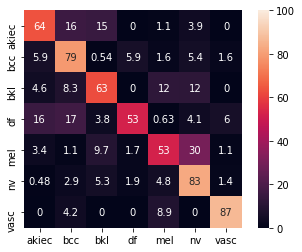

In [29]:
# Confusion matrix

confmat = torchmetrics.ConfusionMatrix(num_classes=7, normalize='true')
model.eval()
with torch.no_grad():
        for x, y_true in val_loader:
                y_pred = F.softmax(model(x), dim=1)
                confmat(y_pred, y_true)

classes = ('akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc')
sns.heatmap(confmat.compute()*100.0, annot=True, square=True, vmin=0.0, vmax=100.0, xticklabels=classes, yticklabels=classes)

In [28]:
# Save the model if we like it.

path = project_path + '/models/ResNet.pth'
#torch.save(model.state_dict(), path)